In [1]:
import os

print(os.listdir('.'))
print(os.getcwd())
os.chdir('/home/robsyc/Desktop/thesis/MB-VAE-DTI/')

['data.ipynb', 'models.ipynb']
/home/robsyc/Desktop/thesis/MB-VAE-DTI/notebooks


---
---

# Loading, Cleaning, and Preprocessing DTI Datasets

Davis and KIBA datasets, see: https://tdcommons.ai/multi_pred_tasks/dti#davis

Datasets are downloaded from the official [`tdc`](https://pypi.org/project/PyTDC/) package. Random and cold splits are generated through their built-in functions. Additionally, a few filters are applied to remove non-drug-like molecules and targets larger than 1024 amino acids. Lastly, the y interaction value is transformed according to standard practice in the field.

Several visualization of the resulting datasets are provided to give a sense of the data distribution.

Found local copy...
Loading...
Done!
To log space...
Found local copy...
Loading...


Loading DAVIS dataset...
Loading KIBA dataset...


Done!


Exploring DAVIS dataset...


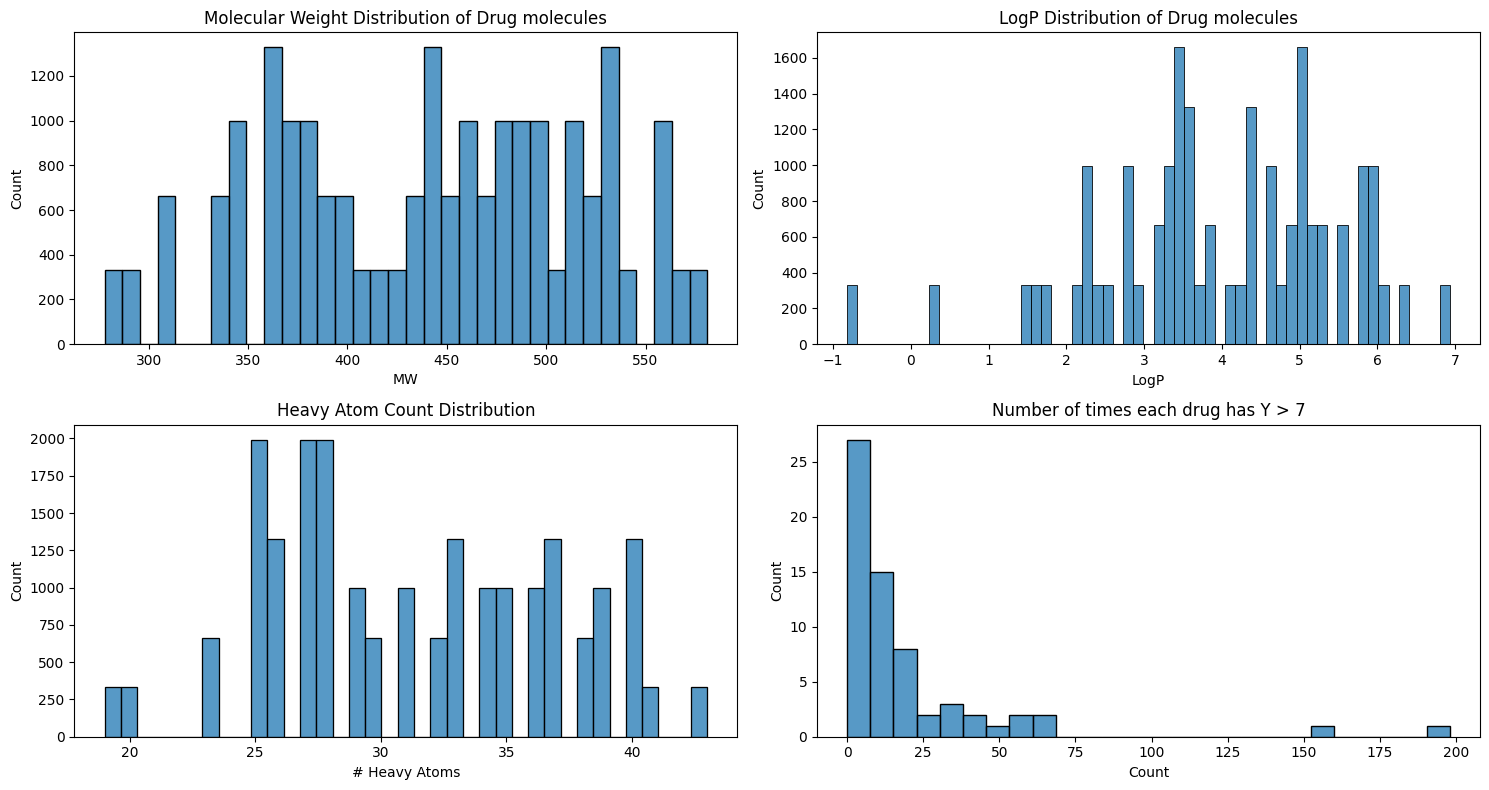

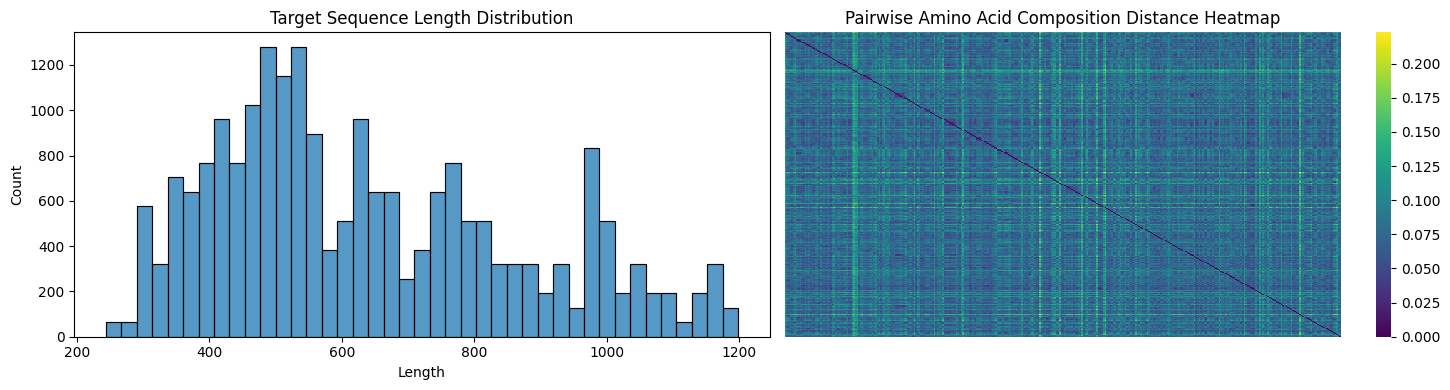

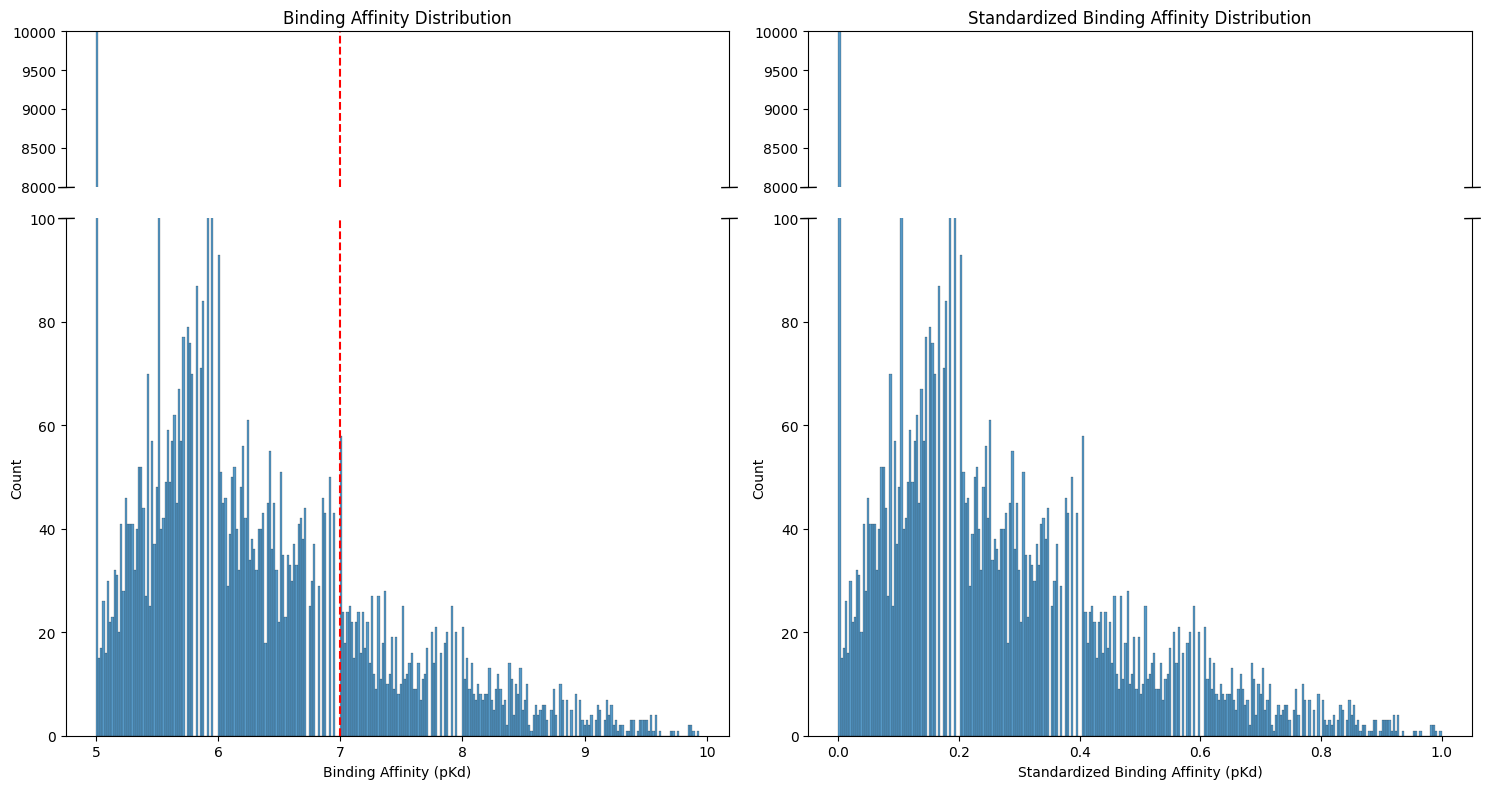

Exploring KIBA dataset...


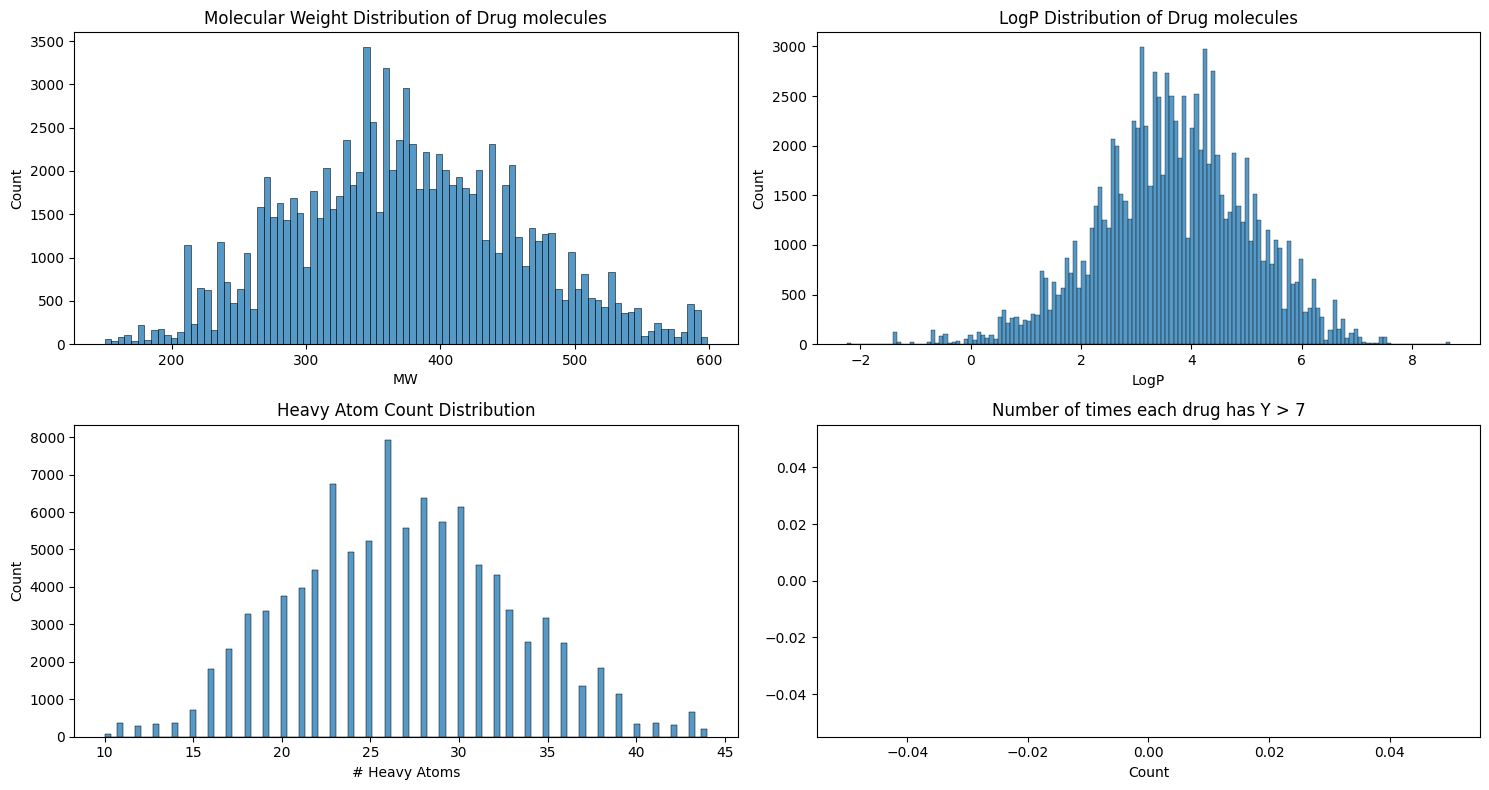

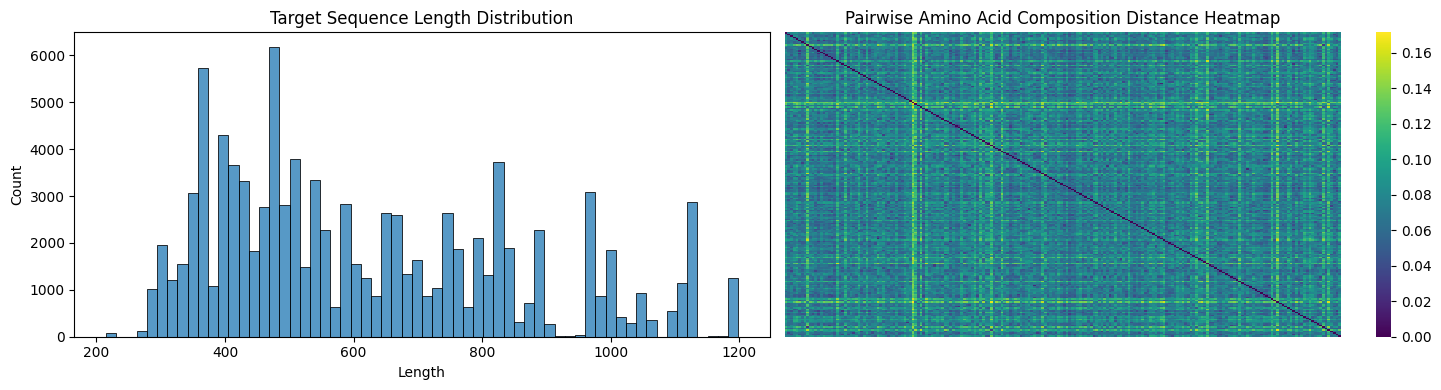

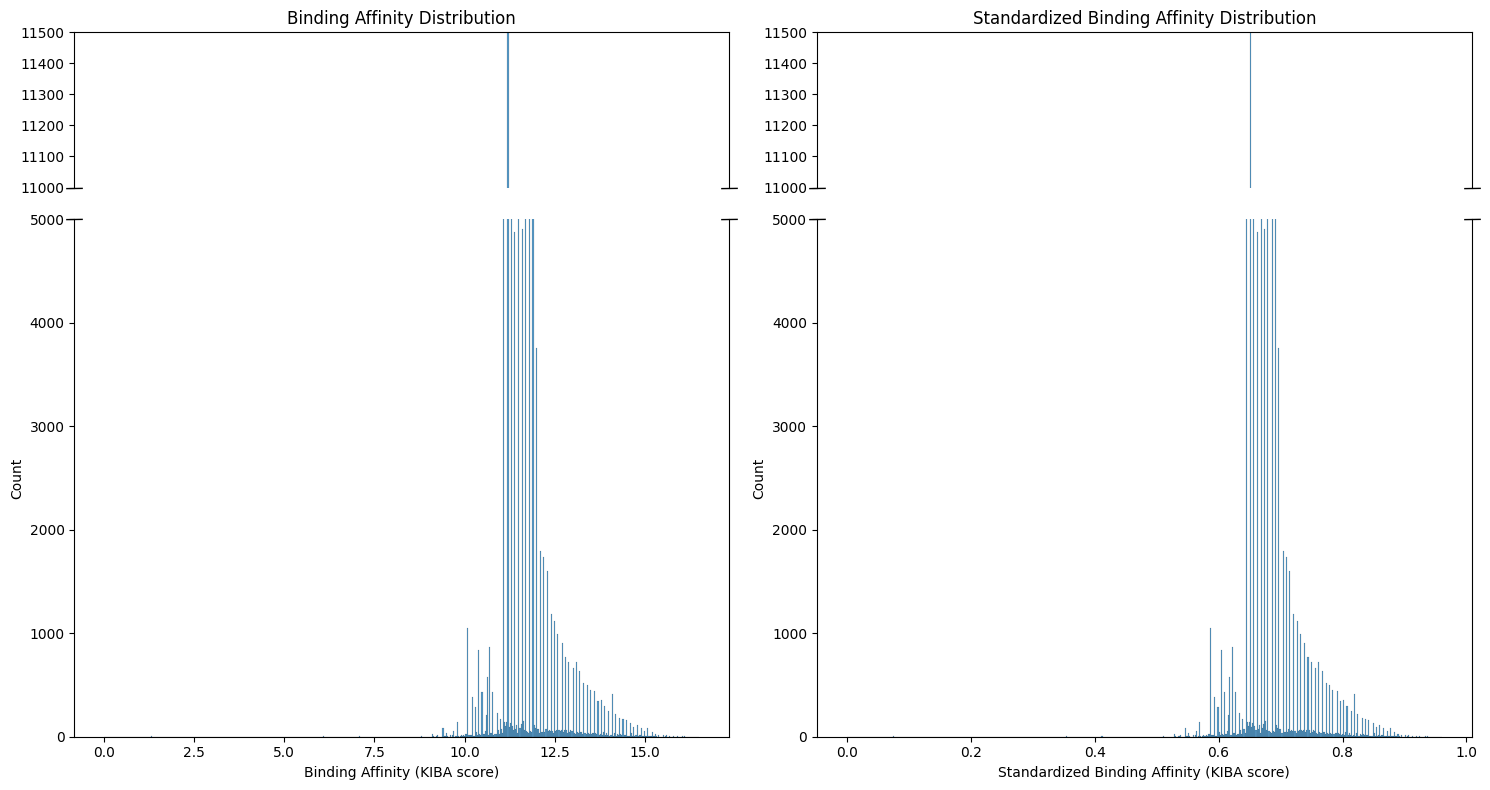

In [2]:
from utils.dataProcessing import load_df, explore_df

df_davis = load_df(
    name="DAVIS",
    use_filters=True,
    to_log=True,
    seed=42
)
df_kiba = load_df(
    name="KIBA",
    use_filters=True,
    to_log=False,
    seed=42
)

explore_df(df_davis, name="DAVIS")
explore_df(df_kiba, name="KIBA")

In [3]:
for df, name in zip([df_davis, df_kiba], ["DAVIS", "KIBA"]):
    print(f"\n{name} dataset")
    print(f"Number of drugs\t\t: {df['Drug'].nunique():,}")
    print(f"Number of targets\t: {df['Target'].nunique():,}")
    print(f"Number of interactions\t: {len(df):,}")


DAVIS dataset
Number of drugs		: 64
Number of targets	: 332
Number of interactions	: 21,248

KIBA dataset
Number of drugs		: 1,957
Number of targets	: 206
Number of interactions	: 100,398


---
---

# Creating the Datasets

We use the [`h5torch`](https://h5torch.readthedocs.io/en/latest/index.html) package for saving our datasets. This format conveniently allows for fast loading of the data and easy access in PyTorch. Furthermore, we'll enrich the DTI dataset by adding a 'DNA view' to our protein targets using the `Target_ID`. Note: these IO operations run fow a while and DAVIS's `Target_ID` key is often ambiguous. Manual curation using BLASTP was perfomed on exceptions. Resulting DNA sequences were saved in `DAVIS_target_seq_DNA.fasta`.

In [4]:
from utils.dataProcessing import generate_h5torch

generate_h5torch(df_davis, "DAVIS")
# generate_h5torch(df_kiba, "KIBA") # davis not yet fetching DNA sequences properly (wrong target ID?)

0 AAK1
2886
1 ABL1p
No CDS found for target ABL1
No length for sequence
2 ABL2
3504
3 ACVR1
1530
4 ACVR2A
1542
5 ADCK3
1944
6 ADCK4
1635
7 AKT1
1443
8 AKT2
1446
9 AKT3
1440
10 AMPK-alpha1
1680
11 AMPK-alpha2
No CDS found for target AMPK alpha 2
No length for sequence
12 ANKK1
2298
13 AURKB
1035
14 AURKC
930
15 BLK
No CDS found for target BLK
No length for sequence
16 BMPR1A
1599
17 BMPR1B
1509
18 BMPR2
3117
19 BRSK1
2337
20 BRSK2
2211
21 CAMK1D
1158
22 CAMK2A
1437
23 CAMK2B
2001
24 CAMK2G
No CDS found for target CAMK2G
No length for sequence
25 CAMK4
1422
26 CAMKK1
1518
27 CASK
2781
28 CDC2L2
No CDS found for target CDC2L2
No length for sequence
29 CDC2L5
975
30 CDK11
No CDS found for target CDK11
No length for sequence
31 CDK2
897
32 CDK5
879
33 CDK8
1395
34 CDK9
1119
35 CDKL2
1482
36 CDKL3
1779
37 CDKL5
3093
38 CHEK1
1431
39 CHEK2
1632
40 CLK1
1455
41 CLK2
1500
42 CLK3
No CDS found for target CLK3
No length for sequence
43 CLK4
1446
44 CSF1R
2919
45 CSNK1A1
1014
46 CSNK1A1L
1014
47 C

In [5]:
# Example use
import h5torch

davis_train_dataset = h5torch.Dataset(
    "./data/dataset/DAVIS.h5t",
    sampling="coo",
    subset=("unstructured/split_rand", "train"),
    in_memory=True,
)

len(davis_train_dataset), davis_train_dataset[100]

(14855,
 {'central': 4.9999957,
  '0/Drug_ID': '11314340',
  '0/Drug_SMILES': 'Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12',
  '1/Target_ID': 'JNK3',
  '1/Target_seq': 'MSLHFLYYCSEPTLDVKIAFCQGFDKQVDVSYIAKHYNMSKSKVDNQFYSVEVGDSTFTVLKRYQNLKPIGSGAQGIVCAAYDAVLDRNVAIKKLSRPFQNQTHAKRAYRELVLMKCVNHKNIISLLNVFTPQKTLEEFQDVYLVMELMDANLCQVIQMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTAGTSFMMTPYVVTRYYRAPEVILGMGYKENVDIWSVGCIMGEMVRHKILFPGRDYIDQWNKVIEQLGTPCPEFMKKLQPTVRNYVENRPKYAGLTFPKLFPDSLFPADSEHNKLKASQARDLLSKMLVIDPAKRISVDDALQHPYINVWYDPAEVEAPPPQIYDKQLDEREHTIEEWKELIYKEVMNSEEKTKNGVVKGQPSPSGAAVNSSESLPPSSSVNDISSMSTDQTLASDTDSSLEASAGPLGCCR',
  '1/Target_seq_DNA': 'ATGAGCAAAAGCAAAGTTGACAACCAGTTCTACAGTGTGGAAGTGGGAGACTCAACCTTCACAGTTCTCAAGCGCTACCAGAATCTAAAGCCTATTGGCTCTGGGGCTCAGGGCATAGTTTGTGCCGCGTATGATGCTGTCCTTGACAGAAATGTGGCCATTAAGAAGCTCAGCAGACCCTTTCAGAACCAAACACATGCCAAGAGAGCGTACCGGGAGCTGGTCCTCATGAAGTGTGTGAACCATAAAAACATTATTAGTTTATTAAATGTCTTCACACCCCAGAAAACGCTGGAGGAGTTCCAAGATGTTTACTTAGTAATGGAACTGATGGATGCC

In [6]:
import torch
torch.set_printoptions(precision=20)

# note that the items must be decoded from bytes with e.g. `item.decode('utf-8')`
davis_train_dataloader = torch.utils.data.DataLoader(davis_train_dataset, batch_size=4, shuffle=True)
batch = next(iter(davis_train_dataloader))
batch

{'central': tensor([4.99999570846557617188, 4.99999570846557617188, 6.72101783752441406250,
         4.99999570846557617188]),
 '0/Drug_ID': ['24889392', '24889392', '3062316', '10184653'],
 '0/Drug_SMILES': ['CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCCN5CCOCC5)ccc34)cc2)no1',
  'CC(C)(C)c1cc(NC(=O)Nc2ccc(-c3cn4c(n3)sc3cc(OCCN5CCOCC5)ccc34)cc2)no1',
  'Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(N2CCN(CCO)CC2)n1',
  'CN(C)CC=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OC1CCOC1'],
 '1/Target_ID': ['BTK', 'HPK1', 'ADCK3', 'PIP5K1A'],
 '1/Target_seq': ['MAAVILESIFLKRSQQKKKTSPLNFKKRLFLLTVHKLSYYEYDFERGRRGSKKGSIDVEKITCVETVVPEKNPPPERQIPRRGEESSEMEQISIIERFPYPFQVVYDEGPLYVFSPTEELRKRWIHQLKNVIRYNSDLVQKYHPCFWIDGQYLCCSQTAKNAMGCQILENRNGSLKPGSSHRKTKKPLPPTPEEDQILKKPLPPEPAAAPVSTSELKKVVALYDYMPMNANDLQLRKGDEYFILEESNLPWWRARDKNGQEGYIPSNYVTEAEDSIEMYEWYSKHMTRSQAEQLLKQEGKEGGFIVRDSSKAGKYTVSVFAKSTGDPQGVIRHYVVCSTPQSQYYLAARNCLVNDQGVVKVSDFGLSRYVLDDEYTSSVGSKFPVRWSPPEVLMYSKFSSKSDIWAFGVLMWEIYSLGKMPYERFTNSETAEHIAQGLRLYRPHLASEKV

---
---

# Embeddings and Fingerprints

Because we will (for now) not be fine-tuning the foundation models used, we pre-compute the embeddings associated with the drug (SMILES strings) and targets (amino acid sequence) data. These embeddings are then saved in the same `h5t` file as the datasets.

For each entitiy (drug and target), we generate a fingerprint and three embeddings using different DL models - emphasising their various 'views'. The following models were used:

- Molecule Drugs
  - Molecule **fingerprints** with [`RDKIT's GetFingerprint method`](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)
  - Graph, Image and Text embedding using [`ibm/biomed.sm.mv-te-84m`](https://huggingface.co/ibm/biomed.sm.mv-te-84m)
- Protein Targets
  - Protein **fingerprints** with [`ESPF adapted from DeepPurpose`](https://github.com/kexinhuang12345/DeepPurpose)
  - Structure-infused embeddings with [`Rostlab/ProstT5`](https://huggingface.co/Rostlab/ProstT5)
  - Protein sequence embeddings with [`facebook/esm2_t36_3B_UR50D`](https://huggingface.co/facebook/esm2_t36_3B_UR50D)
  - DNA sequence embeddings with multispecies [`zhihan1996/DNABERT-2-117M`](https://huggingface.co/zhihan1996/DNABERT-2-117M)

# Generating fingerprints

In [23]:
from utils.preEmbedding import get_drug_fingerprint

SMILES = 'CC(C)N1NC(=C2C=c3cc(O)ccc3=N2)c2c(N)ncnc21'
fp = get_drug_fingerprint(SMILES)
fp.shape, sum(fp), fp

((2048,), 47, array([0, 1, 0, ..., 0, 0, 0]))

In [24]:
from utils.preEmbedding import get_target_fingerprint

s = "MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL"
v = get_target_fingerprint(s)
v.shape, sum(v), v

((4170,), 20.0, array([0., 0., 0., ..., 0., 0., 0.]))

## Generating embeddings

In [8]:
from utils.preEmbedding import BiomedMultiViewMoleculeEncoder

encoder = BiomedMultiViewMoleculeEncoder(
    inference_mode=True,
    huggingface=False
)

SMILES_list = ['CC(C)N1NC(=C2C=c3cc(O)ccc3=N2)c2c(N)ncnc21', 'CC(C)N1NC(=C2C=c3cc(O)ccc3=N2)c2c(N)ncnc21']
graph_emb, image_emb, text_emb = encoder(SMILES_list)
graph_emb.shape, image_emb.shape, text_emb.shape

2024-11-27 23:08:31,653 - root - INFO - pop-os:129779125886720:0:0 - BioMed Multi-view embedding model
2024-11-27 23:08:31,653 - root - INFO - pop-os:129779125886720:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2024-11-27 23:08:31,662 - root - INFO - pop-os:129779125886720:0:0 - Loading checkpoint from provided path ./data/model_saves/Biomed-smmv/biomed-smmv-base.pth
2024-11-27 23:08:31,789 - root - INFO - pop-os:129779125886720:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_tas

(torch.Size([2, 512]), torch.Size([2, 512]), torch.Size([2, 768]))

In [11]:
from utils.preEmbedding import T5ProstTargetEncoder
import torch

encoder = T5ProstTargetEncoder(
    huggingface=False
)

target_list = ['MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL', 'MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL']
target_emb = encoder(target_list)
target_emb.shape

torch.Size([2, 1024])

In [212]:
from utils.preEmbedding import ESMTargetEncoder

encoder = ESMTargetEncoder()

target_list = ['MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL', 'MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL']
target_emb = encoder(target_list)
target_emb.shape

Using HuggingFace model


AssertionError: ESPF directory does not exist.

The pre-trained amino acid / DNA transformer models are quite compute-intensive. See the `./scripts` directory to run them from a terminal and add the generated embeddings to the `h5torch` file (13.2 MB). 

In [241]:
import h5torch

f = h5torch.File("./data/dataset/DAVIS.h5t", "r")
dataset = h5torch.Dataset("./data/dataset/DAVIS.h5t", sampling="coo", subset=("unstructured/split_rand", "train"))

print(f"Number of drug-target pairs: {len(dataset):,}")
print("Number of drugs: ", len(f["0/Drug_ID"][:]))
print("Number of targets: ", len(f["1/Target_ID"][:]))

example = dataset[0]
for key in example.keys():
    print('\n', key, str(example[key])[:100])

    try:
        print(len(example[key]), example[key].shape)
    except:
        print(example[key].shape)
    

Number of drug-target pairs: 14,855
Number of drugs:  63
Number of targets:  331

 central 7.365523
()

 0/Drug_ID 11314340
8 ()

 0/Drug_SMILES Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12
45 ()

 0/Drug_emb_graph [ 2.17160732e-02  4.08728383e-02 -7.49700963e-02 -2.17908949e-01
  1.02013923e-01 -5.46889007e-03  6
512 (512,)

 0/Drug_emb_image [0.8404914  0.40870777 0.8514618  0.80295545 0.58690625 0.6113297
 0.7583807  0.72116286 0.81895244 
512 (512,)

 0/Drug_emb_text [ 6.96798742e-01 -3.04111004e-01  2.36284211e-01 -1.52290925e-01
  9.75478232e-01 -4.68682289e-01  2
768 (768,)

 0/Drug_fp [0. 1. 0. ... 0. 0. 0.]
2048 (2048,)

 1/Target_ID AAK1
4 ()

 1/Target_emb_DNA [ 0.01063396  0.05548084 -0.36506686 ... -0.06219901  0.50660896
  0.04698246]
1024 (1024,)

 1/Target_emb_ESM [ 0.00523894 -0.07060045 -0.03749474 ... -0.06131146  0.060923
  0.1215151 ]
1280 (1280,)

 1/Target_emb_T5 [-0.04721069 -0.00399399 -0.07196045 ... -0.04202271 -0.04751587
  0.02128601]
1024 (1024,)

 1/Targ